<a href="https://colab.research.google.com/github/duduremiao/ExerciciosCG-GA/blob/main/An%C3%A1lise_e_Recomenda%C3%A7%C3%A3o_de_Filmes_com_PySpark_25M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise e Recomendação de Filmes com PySpark**

**Eduardo Arruda Remião e Rafael do Amaral Porciuncula**






---



**Instalar bibliotecas necessárias**

In [ ]:
!pip install pyspark findspark kagglehub matplotlib



---



**Importando bibliotecas necessárias**

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, split, explode
import matplotlib.pyplot as plt



---



**Criar sessão Spark**

In [ ]:

spark = SparkSession.builder \
    .appName("MovieLens25M Analysis and Recommendations") \
    .getOrCreate()



---



**Baixar dataset do Kaggle**

In [ ]:
import kagglehub


path = kagglehub.dataset_download("garymk/movielens-25m-dataset")
print("Dataset saved at:", path)

100%|██████████| 258M/258M [00:02<00:00, 90.8MB/s]

Extracting files...


Dataset saved at: /root/.cache/kagglehub/datasets/garymk/movielens-25m-dataset/versions/1




---



**Caminhos para os arquivos do dataset MovieLens 25M**

In [ ]:
ratings_path = f"{path}/ml-25m/ratings.csv"
movies_path = f"{path}/ml-25m/movies.csv"



---



**Carregar os dados**



*   **sep=**"," : O separador usado nos arquivos CSV é uma vírgula (,)

*   **header=**True : Este parâmetro indica que a primeira linha do arquivo contém os nomes das colunas, ou seja, será usada como cabeçalho para o DataFrame.

*   **inferSchema=**True : Este parâmetro solicita que o PySpark automaticamente determine o tipo de dados de cada coluna com base nos valores presentes no arquivo CSV.




In [ ]:
# Carregar o arquivo de avaliações
ratings = spark.read.csv(
    ratings_path,
    sep=",",
    header=True,
    inferSchema=True
)

# Carregar o arquivo de filmes
movies = spark.read.csv(
    movies_path,
    sep=",",
    header=True,
    inferSchema=True
)

# Verificar esquemas
print("Esquema de Ratings:")
ratings.printSchema()

print("Esquema de Movies:")
movies.printSchema()


Esquema de Ratings:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

Esquema de Movies:
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)





---



**Análise Exploratória**

*   **ratings.groupBy("movieId")** : Agrupa os dados do DataFrame ratings pela coluna movieId

*   **groupBy()** agrupa as avaliações por filme

*   **.count()** : conta quantas avaliações existem para cada filme

*   **.orderBy("count", ascending=False)** : O DataFrame é ordenado com base na coluna count (nº de avaliações) de forma decrescente (ascending=False).





In [ ]:
# Contagem de avaliações por filme
top_movies = ratings.groupBy("movieId") \
    .count() \
    .join(movies, "movieId") \
    .orderBy("count", ascending=False)

print("Top 10 filmes mais avaliados:")
top_movies.show(10, truncate=False)

Top 10 filmes mais avaliados:
+-------+-----+-----------------------------------------+--------------------------------+
|movieId|count|title                                    |genres                          |
+-------+-----+-----------------------------------------+--------------------------------+
|356    |81491|Forrest Gump (1994)                      |Comedy|Drama|Romance|War        |
|318    |81482|Shawshank Redemption, The (1994)         |Crime|Drama                     |
|296    |79672|Pulp Fiction (1994)                      |Comedy|Crime|Drama|Thriller     |
|593    |74127|Silence of the Lambs, The (1991)         |Crime|Horror|Thriller           |
|2571   |72674|Matrix, The (1999)                       |Action|Sci-Fi|Thriller          |
|260    |68717|Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi         |
|480    |64144|Jurassic Park (1993)                     |Action|Adventure|Sci-Fi|Thriller|
|527    |60411|Schindler's List (1993)                  |Dra



---



**Exibir os 10 filmes com melhores médias (considerando pelo menos 10.000 avaliações)**

*   **ratings.groupBy("movieId")** : Agrupa as avaliações no DataFrame ratings pela coluna movieId
*   **.agg()** : Usada para realizar agregações nos grupos

*   **count("rating")** : Conta o número total de avaliações feitas para cada filme.
*  **avg("rating")** : Calcula a média das avaliações para cada filme

*   **.filter("num_ratings >= 10000")** : Mantém apenas os filmes que possuem pelo menos 10.000 avaliações

*   **.join(movies, "movieId")** : O DataFrame filtered_ratings é combinado com o DataFrame movies, que contém informações sobre os filmes

*   **.orderBy("average_rating", ascending=False)** : Ordenação pela coluna average_rating de forma decrescente (ascending=False)

In [ ]:
from pyspark.sql.functions import avg, count

# Contar número de avaliações por filme
ratings_count = ratings.groupBy("movieId") \
    .agg(
        count("rating").alias("num_ratings"),
        avg("rating").alias("average_rating")
    )

# Filtrar filmes com pelo menos 10.000 avaliações
filtered_ratings = ratings_count.filter("num_ratings >= 10000")

# Juntar com o DataFrame de filmes e ordenar por média de avaliação
average_ratings = filtered_ratings.join(movies, "movieId") \
    .orderBy("average_rating", ascending=False)


print("Top 10 filmes com melhores médias de avaliação (min. 10.000 avaliações):")
average_ratings.select("title", "average_rating", "num_ratings").show(10, truncate=False)


Top 10 filmes com melhores médias de avaliação (min. 10.000 avaliações):
+-------------------------------------------+------------------+-----------+
|title                                      |average_rating    |num_ratings|
+-------------------------------------------+------------------+-----------+
|Shawshank Redemption, The (1994)           |4.413576004516335 |81482      |
|Godfather, The (1972)                      |4.324336165187245 |52498      |
|Usual Suspects, The (1995)                 |4.284353213163313 |55366      |
|Godfather: Part II, The (1974)             |4.2617585117585115|34188      |
|Seven Samurai (Shichinin no samurai) (1954)|4.25476920775043  |13367      |
|Schindler's List (1993)                    |4.247579083279535 |60411      |
|12 Angry Men (1957)                        |4.243014062405697 |16569      |
|Rear Window (1954)                         |4.237947624243627 |20162      |
|Fight Club (1999)                          |4.228310618821568 |58773      |
|On



---



**Distribuição de ratings**



*   **ratings.select("rating")** : Selecionado apenas a coluna rating do DataFrame ratings
*   **.groupBy("rating")** : Agrupa os dados pela coluna rating
*   **.count()** : Conta quantas vezes cada nota (rating) aparece no DataFrame
*   **.orderBy("rating")** : Ordena os resultados pelo valor da coluna rating
*   **.show()** : Exibe o resultado na tela.



In [ ]:
ratings_distribution = ratings.select("rating") \
    .groupBy("rating") \
    .count() \
    .orderBy("rating")

ratings_distribution.show()


+------+-------+
|rating|  count|
+------+-------+
|   0.5| 393068|
|   1.0| 776815|
|   1.5| 399490|
|   2.0|1640868|
|   2.5|1262797|
|   3.0|4896928|
|   3.5|3177318|
|   4.0|6639798|
|   4.5|2200539|
|   5.0|3612474|
+------+-------+





---



**Processar gêneros**


*   **split(col("genres"), "\\|")** : A função split divide o conteúdo da coluna genres em uma lista de gêneros.
*   *   O valor na coluna genres é uma string com gêneros separados por pipe (|), por exemplo: "Action|Adventure|Sci-Fi".
*   *   O comando split quebra essa string em uma lista de gêneros, como ["Action", "Adventure", "Sci-Fi"]

*   **explode(col("genres"))** : A função explode pega a lista de gêneros de cada filme e cria uma linha separada para cada gênero

*   **filter(col("genre") == "Action")** : Este comando filtra os filmes que têm o gênero "Action" na coluna genre criada na etapa anterior



In [ ]:
# Dividir a coluna 'genres' em uma lista e explodir
movies = movies.withColumn("genres", split(col("genres"), "\\|"))
movies_exploded = movies.withColumn("genre", explode(col("genres")))

# Exemplo: Filmes de Ação
action_movies = movies_exploded.filter(col("genre") == "Action")

print("Exemplo de filmes de ação:")
action_movies.show(10, truncate=False)

Exemplo de filmes de ação:
+-------+-----------------------------------------+----------------------------------------+------+
|movieId|title                                    |genres                                  |genre |
+-------+-----------------------------------------+----------------------------------------+------+
|6      |Heat (1995)                              |[Action, Crime, Thriller]               |Action|
|9      |Sudden Death (1995)                      |[Action]                                |Action|
|10     |GoldenEye (1995)                         |[Action, Adventure, Thriller]           |Action|
|15     |Cutthroat Island (1995)                  |[Action, Adventure, Romance]            |Action|
|20     |Money Train (1995)                       |[Action, Comedy, Crime, Drama, Thriller]|Action|
|23     |Assassins (1995)                         |[Action, Crime, Thriller]               |Action|
|42     |Dead Presidents (1995)                   |[Action, Crime, Drama]



---



**Recomendação de Filmes**



*   **ratings.randomSplit([0.8, 0.2], seed=42)** : randomSplit divide o DataFrame ratings em dois conjuntos: 80% train e 20% test
*   *   O seed=42 garante que sempre que executar o código, a divisão dos dados seja a mesma.



**ALS** : O algoritmo Alternating Least Squares (ALS) é uma técnica de fatoração de matrizes usada para recomendação em sistemas baseados em dados de interação, como no caso de filmes, músicas, etc.


*   **maxIter=10** : Nº máximo de iterações que o algoritmo fará para tentar otimizar a decomposição das matrizes (reduzir o erro)
*   **regParam=0.1** : Parâmetro que ajuda a evitar o overfitting (modelo não generaliza bem para novos dados)
*  **userCol="userId"** : Coluna no DataFrame que contém os identificadores dos usuários
*   **itemCol="movieId"** : Coluna que contém os identificadores dos itens (filmes)
*   **ratingCol="rating"** : Coluna que contém as avaliações feitas pelos usuários.
*   **coldStartStrategy="drop"** : Usado para lidar com o problema de cold start (quando o modelo tenta fazer previsões para um usuário ou item que não tem dados suficientes)
*   *   **drop** : Remover os casos de cold start (usuários ou itens com pouca ou nenhuma interação nos dados)


In [ ]:
# Dividir dados em treino e teste
train, test = ratings.randomSplit([0.8, 0.2], seed=42)

# Importar ALS para recomendação
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Configurar modelo ALS
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)




---



# **Treinar o modelo**

In [ ]:
model = als.fit(train)



---



**Avaliar o modelo no conjunto de teste**


*   O método ***transform*** aplica o modelo treinado ao conjunto de teste. O conjunto de teste contém interações que o modelo ainda não viu, ou seja, avaliações dos filmes feitas pelos usuários




In [ ]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 0.8077452488113767




---



**Recomendação personalizada para o usuário id 1**


*   **model.recommendForAllUsers(10)** : Gera as 10 melhores recomendações para todos os usuários do conjunto de dados.
*   *   A função retorna um DataFrame contendo as recomendações de filmes para cada usuário.
*   **filter(col("userId") == user_id)** : Filtra o DataFrame gerado para obter apenas as recomendações do usuário com o user_id=1



In [ ]:
user_id = 1
user_recommendations = model.recommendForAllUsers(10)
recommendations = user_recommendations.filter(col("userId") == user_id)

print(f"Recomendações para o usuário {user_id}:")
recommendations.show(truncate=False)

Recomendações para o usuário 1:
+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                            |
+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{177209, 5.4461946}, {183947, 5.278643}, {192089, 5.2052555}, {143422, 5.009919}, {165559, 4.9957924}, {93991, 4.951272}, {144208, 4.8712063}, {166812, 4.86883}, {165689, 4.852002}, {203086, 4.8440785}]|
+------+------------------------------------------------------------------------------------------------------------



---



**Recomendações com títulos**


*   **explode("recommendations")** :
*   *   A coluna recommendations, gerada pelo modelo ALS, contém uma lista de objetos (movieId e rating).
*   *   O método ***explode*** transforma essa lista em várias linhas, onde cada linha contém apenas um item da lista
*   **select("userId", explode(...))** : A nova tabela resultante terá duas colunas: *userId* e *recommendation* (contendo movieId e rating)
*   **join(movies, "movieId")** : Realiza um join entre as tabelas recommendations e movies com base na coluna movieId.




In [ ]:
recommendations = recommendations.select("userId", explode("recommendations").alias("recommendation"))
recommendations = recommendations.select("userId", col("recommendation.movieId").alias("movieId"), col("recommendation.rating").alias("predicted_rating"))

recommendations_with_titles = recommendations.join(movies, "movieId")

print(f"Recomendações para o usuário {user_id} com títulos:")
recommendations_with_titles.show(10, truncate=False)

Recomendações para o usuário 1 com títulos:
+-------+------+----------------+--------------------------------------------------+---------------------------+
|movieId|userId|predicted_rating|title                                             |genres                     |
+-------+------+----------------+--------------------------------------------------+---------------------------+
|177209 |1     |5.4461946       |Acı Aşk (2009)                                    |[Drama]                    |
|183947 |1     |5.278643        |NOFX Backstage Passport 2                         |[(no genres listed)]       |
|192089 |1     |5.2052555       |National Theatre Live: One Man, Two Guvnors (2011)|[Comedy]                   |
|143422 |1     |5.009919        |2 (2007)                                          |[Drama]                    |
|165559 |1     |4.9957924       |Ο Θανάσης στη χώρα της σφαλιάρας (1976)           |[(no genres listed)]       |
|93991  |1     |4.951272        |Eye for an Eye, An 



---



**Visualização de Dados**

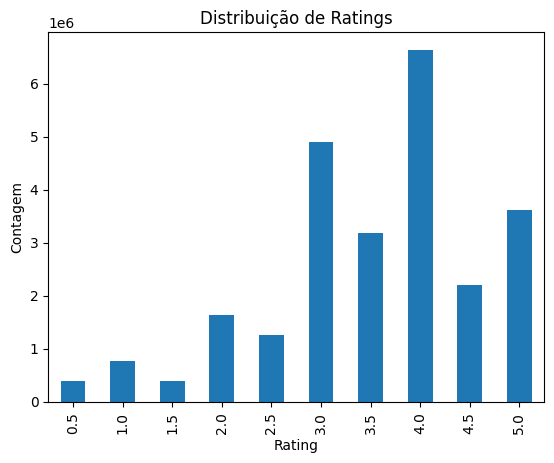

In [ ]:
# Converter distribuição de ratings para Pandas e plotar
ratings_distribution_pd = ratings_distribution.toPandas()
ratings_distribution_pd.plot(kind='bar', x='rating', y='count', legend=False, title='Distribuição de Ratings')
plt.xlabel("Rating")
plt.ylabel("Contagem")
plt.show()



---



**Visualizar recomendações para o usuário**

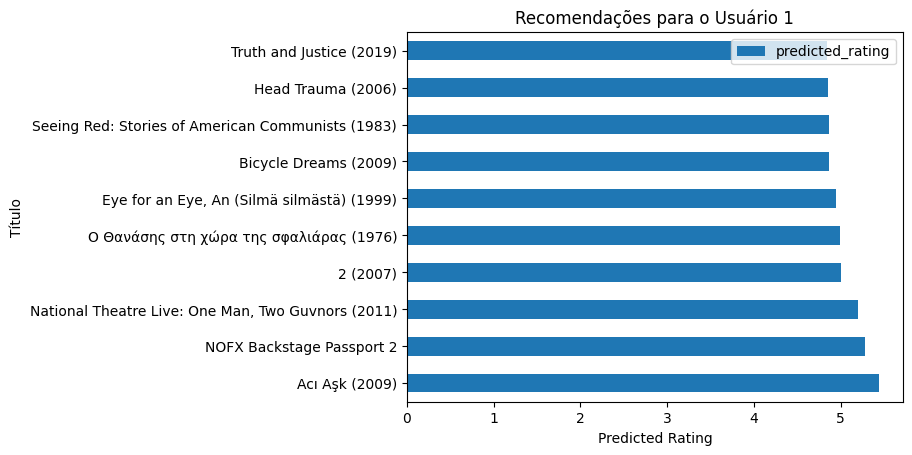

In [ ]:
user_recommendations_df = recommendations_with_titles.toPandas()
user_recommendations_df.plot(kind="barh", x="title", y="predicted_rating", title=f"Recomendações para o Usuário {user_id}")
plt.xlabel("Predicted Rating")
plt.ylabel("Título")
plt.show()



---



**Finalizar e salvar**

In [ ]:
# Salvar recomendações em CSV
from pyspark.sql.functions import concat_ws

# Converter a coluna 'genres' (ARRAY<STRING>) em uma string delimitada
recommendations_with_titles = recommendations_with_titles.withColumn(
    "genres", concat_ws(",", "genres")
)

# Salvar em CSV
recommendations_with_titles.write.mode("overwrite").csv("recommendations_with_titles.csv", header=True)

print("Processo concluído com sucesso!")


Processo concluído com sucesso!
